# Copyright Netherlands eScience Center <br>
** Function     : Calculate AMET as the residual of net flux at TOA and surface ** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2018.09.24 ** <br>
** Last Update  : 2018.09.24 ** <br>
Description  : This script serves to calculate the meridional energy transport in the atmosphere as the residual of net radiation flux at top of the atmosphere and the net surface flux at the sea surface. The fields are estimated from ERA-Interim.<br>
Return Values : jpeg <br>
Caveat!         : The AMET is computed as the residual of net flux at TOA and surface. <br>
For all the flux generated by ECMWF model, **downward is positive** (regardless of the standard name). So it is with **ERA-Interim** <br>
While for the flux in **MERRA2**, the **positive sign** for each variable varies:<br>
* Net shortwave radiation at surface - downward <br>
* Net shortwave radiation at TOA - downward <br>
* Net longwave radiation at surface - downward <br>
* Upwelling longwave radiation at TOA - upward <br>
* Total latent energy flux - upward <br>
* Sensible heat flux - upward <br>

While for the flux in **JRA55**, the **positive sign** for each variable varies:<br>
* Latent heat flux - upward <br>
* Sensible heat flux - upward <br>
* Downward solar radiation flux at TOA - downward <br>
* Downward solar radiation flux at surface - downward <br>
* Downward longwave radiation flux at surface - downward <br>
* Upward solar radiation flux at TOA - upward <br>
* Upward solar radiation flux at surface - upward <br>
* Upward longwave radiation flux at TOA - upward <br>
* Upward longwave radiation flux at surface - upward <br>

Here we use the net radiation flux of JRA55 after post-processing, as follows: <br>
* Net radiation at TOA - downward <br>
* Net radiation at surface - downward <br>

In [20]:
%matplotlib inline

import sys
sys.path.append("/home/yang/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer
from scipy import stats

Initialization - Start with location of input and extraction of variables
Time span of each product:
- **ERA-Interim** 1979 - 2016
- **MERRA2**      1980 - 2016
- **JRA55**       1979 - 2015
- **ORAS4**       1958 - 2017
- **GLORYS2V3**   1993 - 2014
- **SODA3**       1980 - 2015

In [3]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'HoF' : 334,        # heat of fusion of ice [KJ/Kg] 
            'rho_ice' : 0.91    # density of sea ice [g/cm3]
            }

In [4]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    datapath = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/warehouse_met'
    datapath_ERAI_fields = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
    datapath_MERRA2_AMET = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/MERRA2/postprocessing'
    datapath_MERRA2_fields = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/MERRA2/regression'
    datapath_JRA55_AMET = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/JRA55/postprocessing'
    datapath_JRA55_fields = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/JRA55/regression'
    output_path = '/home/yang/NLeSC/Computation_Modeling/Bjerknes/Compensation/dataExpo/AMET_res_div'
    #####################################################################################
    print ('*********************** extract variables *************************')
    dataset_ERAI_AMET = Dataset(os.path.join(datapath,
                                'era_model_subdaily_1979_2016_amet.nc'))
    dataset_ERAI_AMET = Dataset(os.path.join(datapath,
                                             'era_model_subdaily_1979_2016_amet.nc'))
    dataset_MERRA2_AMET = Dataset(os.path.join(datapath_MERRA2_AMET,
                                               'AMET_MERRA2_model_daily_1980_2016_E_zonal_int.nc'))
    dataset_JRA55_AMET = Dataset(os.path.join(datapath_JRA55_AMET,
                                              'AMET_JRA55_model_daily_1979_2015_E_zonal_int.nc'))
    dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields,
                                                    'surface_erai_monthly_regress_1979_2017_radiation.nc'))
    dataset_MERRA2_fields_flux = Dataset(os.path.join(datapath_MERRA2_fields,
                                                      'surface_merra_monthly_regress_1980_2017_SFlux_Rad.nc'))
    dataset_JRA55_fields_flux = Dataset(os.path.join(datapath_JRA55_fields,
                                                     'surface_JRA55_monthly_model_regress_SFlux_Rad_1979_2013.nc'))
    # extract time series from 1979 to 2016
    # from 20N - 90N
    # 3D fields [year, month, lat]
    AMET_div_int_ERAI = dataset_ERAI_AMET.variables['E_total_int'][:]/1000 # from Tera Watt to Peta Watt
    AMET_div_int_MERRA2 = dataset_MERRA2_AMET.variables['E'][:]/1000
    AMET_div_int_JRA55 = dataset_JRA55_AMET.variables['E'][:]/1000    
    # other dimensions
    year_ERAI = dataset_ERAI_AMET.variables['year']
    year_MERRA2 = dataset_MERRA2_AMET.variables['year']
    year_JRA55 = dataset_JRA55_AMET.variables['year']
    latitude_AMET_ERAI = dataset_ERAI_AMET.variables['latitude'][:]
    latitude_AMET_MERRA2 = dataset_MERRA2_AMET.variables['latitude'][:]
    latitude_AMET_JRA55 = dataset_JRA55_AMET.variables['latitude'][:]
    latitude_fields_ERAI = dataset_ERAI_fields_flux.variables['latitude'][:]
    longitude_fields_ERAI = dataset_ERAI_fields_flux.variables['longitude'][:]
    # reverse the latitude of MERRA2 fields
    latitude_fields_MERRA2 = dataset_MERRA2_fields_flux.variables['latitude'][::-1]
    longitude_fields_MERRA2 = dataset_MERRA2_fields_flux.variables['longitude'][:]
    latitude_fields_JRA55 = dataset_JRA55_fields_flux.variables['latitude'][:]
    longitude_fields_JRA55 = dataset_JRA55_fields_flux.variables['longitude'][:]

*********************** extract variables *************************


In [5]:
    #####################################################################################
    print ('*********************** post-process 4D fields *************************')    
    # 4D fields [year, month, level, lat]
    # downward is positive for all the fluxes
    print ('*********************** post-process era fields *************************')
    rad_short_toa_ERAI = dataset_ERAI_fields_flux.variables['tsr'][:-1,:,:,:]
    rad_long_toa_ERAI = dataset_ERAI_fields_flux.variables['ttr'][:-1,:,:,:]
    rad_short_surf_ERAI = dataset_ERAI_fields_flux.variables['ssr'][:-1,:,:,:]
    rad_long_surf_ERAI = dataset_ERAI_fields_flux.variables['str'][:-1,:,:,:]
    SFlux_sensible_ERAI = dataset_ERAI_fields_flux.variables['sshf'][:-1,:,:,:]
    SFlux_latent_ERAI = dataset_ERAI_fields_flux.variables['slhf'][:-1,:,:,:]
    # calculate total net energy flux at TOA/surface
    net_flux_surf_ERAI = rad_short_surf_ERAI[:] + rad_long_surf_ERAI[:] +\
                         SFlux_sensible_ERAI[:] + SFlux_latent_ERAI[:]
    net_flux_toa_ERAI = rad_short_toa_ERAI[:] + rad_long_toa_ERAI[:]    
    # save memory
    del rad_short_toa_ERAI, rad_long_toa_ERAI, rad_short_surf_ERAI, rad_long_surf_ERAI
    del SFlux_sensible_ERAI, SFlux_latent_ERAI    
    print ('*********************** post-process merra fields *************************')
    rad_short_toa_MERRA2 = dataset_MERRA2_fields_flux.variables['SWTNT'][:-1,:,:,:]
    rad_long_toa_MERRA2 = dataset_MERRA2_fields_flux.variables['LWTUP'][:-1,:,:,:]
    rad_short_surf_MERRA2 = dataset_MERRA2_fields_flux.variables['SWGNT'][:-1,:,:,:]
    rad_long_surf_MERRA2 = dataset_MERRA2_fields_flux.variables['LWGNT'][:-1,:,:,:]
    SFlux_sensible_MERRA2 = dataset_MERRA2_fields_flux.variables['HFLUX'][:-1,:,:,:]
    SFlux_latent_MERRA2 = dataset_MERRA2_fields_flux.variables['EFLUX'][:-1,:,:,:]
    # calculate total net energy flux at TOA/surface
    # merra - watch out! the sign
    # reverse the meridional coordinate of MERRA2 for the sake of the calc. of residual
    net_flux_surf_MERRA2 = rad_short_surf_MERRA2[:,:,::-1,:] + rad_long_surf_MERRA2[:,:,::-1,:] -\
                           SFlux_sensible_MERRA2[:,:,::-1,:] - SFlux_latent_MERRA2[:,:,::-1,:]
    net_flux_toa_MERRA2 = rad_short_toa_MERRA2[:,:,::-1,:] - rad_long_toa_MERRA2[:,:,::-1,:]
    del rad_short_toa_MERRA2, rad_long_toa_MERRA2, rad_short_surf_MERRA2, rad_long_surf_MERRA2
    del SFlux_sensible_MERRA2, SFlux_latent_MERRA2
    print ('*********************** post-process jra fields *************************')
    rad_net_toa_JRA55 = dataset_JRA55_fields_flux.variables['nRadT'][:]
    rad_net_surf_JRA55 = dataset_JRA55_fields_flux.variables['nRadS'][:]
    SFlux_sensible_JRA55 = dataset_JRA55_fields_flux.variables['SFlux'][:]
    SFlux_latent_JRA55 = dataset_JRA55_fields_flux.variables['LFlux'][:]
    # calculate total net energy flux at TOA/surface
    net_flux_surf_JRA55 = rad_net_surf_JRA55[:] + SFlux_sensible_JRA55[:] +\
                          SFlux_latent_JRA55[:]
    net_flux_toa_JRA55 = rad_net_toa_JRA55[:]
    del rad_net_surf_JRA55, SFlux_sensible_JRA55, SFlux_latent_JRA55
    print ('*********************** convert W/m2 to  *************************')
    # area weighted surface flux
    # era
    net_flux_surf_ERAI_area = np.zeros(net_flux_surf_ERAI.shape, dtype=float)
    net_flux_toa_ERAI_area = np.zeros(net_flux_toa_ERAI.shape, dtype=float)
    # merra
    net_flux_surf_MERRA2_area = np.zeros(net_flux_surf_MERRA2.shape, dtype=float)
    net_flux_toa_MERRA2_area = np.zeros(net_flux_toa_MERRA2.shape, dtype=float)
    # jra
    net_flux_surf_JRA55_area = np.zeros(net_flux_surf_JRA55.shape, dtype=float)
    net_flux_toa_JRA55_area = np.zeros(net_flux_toa_JRA55.shape, dtype=float) 
    #size of the grid box
    # era
    dx_ERAI = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_fields_ERAI /
                                            360) / len(longitude_fields_ERAI) 
    dy_ERAI = np.pi * constant['R'] / len(latitude_fields_ERAI)
    # merra
    dx_MERRA2 = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_fields_MERRA2 /
                                            360) / len(longitude_fields_MERRA2) 
    dy_MERRA2 = np.pi * constant['R'] / len(latitude_fields_MERRA2)
    # jra
    dx_JRA55 = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_fields_JRA55 /
                                            360) / len(longitude_fields_JRA55) 
    dy_JRA55 = np.pi * constant['R'] / len(latitude_fields_JRA55)   
    # era
    for i in np.arange(len(latitude_fields_ERAI)):
        # change the unit to terawatt
        net_flux_surf_ERAI_area[:,:,i,:] = net_flux_surf_ERAI[:,:,i,:] * dx_ERAI[i] *\
                                           dy_ERAI / 1E+12
        net_flux_toa_ERAI_area[:,:,i,:] = net_flux_toa_ERAI[:,:,i,:] * dx_ERAI[i] *\
                                          dy_ERAI / 1E+12
    # merra
    for i in np.arange(len(latitude_fields_MERRA2)):
        # change the unit to terawatt
        net_flux_surf_MERRA2_area[:,:,i,:] = net_flux_surf_MERRA2[:,:,i,:] * dx_MERRA2[i] *\
                                           dy_MERRA2 / 1E+12
        net_flux_toa_MERRA2_area[:,:,i,:] = net_flux_toa_MERRA2[:,:,i,:] * dx_MERRA2[i] *\
                                          dy_MERRA2 / 1E+12
    # jra
    for i in np.arange(len(latitude_fields_JRA55)):
        # change the unit to terawatt
        net_flux_surf_JRA55_area[:,:,i,:] = net_flux_surf_JRA55[:,:,i,:] * dx_JRA55[i] *\
                                           dy_JRA55 / 1E+12
        net_flux_toa_JRA55_area[:,:,i,:] = net_flux_toa_JRA55[:,:,i,:] * dx_JRA55[i] *\
                                          dy_JRA55 / 1E+12

*********************** post-process 4D fields *************************
*********************** post-process era fields *************************
*********************** post-process merra fields *************************
*********************** post-process jra fields *************************
*********************** convert W/m2 to  *************************


In [6]:
    print ('Compute AMET as the residuals of net flux at TOA & surface.')
    print ('*********************** AMET - era fields *************************')
    # take the zonal integral of flux
    net_flux_surf_ERAI_int = np.sum(net_flux_surf_ERAI_area,3) / 1000 # PW
    net_flux_toa_ERAI_int = np.sum(net_flux_toa_ERAI_area,3) / 1000
    # AMET as the residual of net flux at TOA & surface
    AMET_res_ERAI = np.zeros(net_flux_surf_ERAI_int.shape)
    for i in np.arange(len(latitude_fields_ERAI)-1):
        AMET_res_ERAI[:,:,i] = -(np.sum(net_flux_toa_ERAI_int[:,:,0:i+1],2) -
                                np.sum(net_flux_surf_ERAI_int[:,:,0:i+1],2))
    print (AMET_res_ERAI.shape)
    print ('*********************** AMET - merra fields *************************')
    # take the zonal integral of flux
    net_flux_surf_MERRA2_int = np.sum(net_flux_surf_MERRA2_area,3) / 1000 # PW
    net_flux_toa_MERRA2_int = np.sum(net_flux_toa_MERRA2_area,3) / 1000
    # AMET as the residual of net flux at TOA & surface
    AMET_res_MERRA2 = np.zeros(net_flux_surf_MERRA2_int.shape)
    for i in np.arange(len(latitude_fields_MERRA2)-1):
        AMET_res_MERRA2[:,:,i] = -(np.sum(net_flux_toa_MERRA2_int[:,:,0:i+1],2) -
                                np.sum(net_flux_surf_MERRA2_int[:,:,0:i+1],2))
    print (AMET_res_MERRA2.shape)    
    print ('*********************** AMET - jra fields *************************')
    # take the zonal integral of flux
    net_flux_surf_JRA55_int = np.sum(net_flux_surf_JRA55_area,3) / 1000 # PW
    net_flux_toa_JRA55_int = np.sum(net_flux_toa_JRA55_area,3) / 1000
    # AMET as the residual of net flux at TOA & surface
    AMET_res_JRA55 = np.zeros(net_flux_surf_JRA55_int.shape)
    for i in np.arange(len(latitude_fields_JRA55)-1):
        AMET_res_JRA55[:,:,i] = -(np.sum(net_flux_toa_JRA55_int[:,:,0:i+1],2) -
                                np.sum(net_flux_surf_JRA55_int[:,:,0:i+1],2))
    print (AMET_res_JRA55.shape)

Compute AMET as the residuals of net flux at TOA & surface.
*********************** AMET - era fields *************************
(38, 12, 241)
*********************** AMET - merra fields *************************
(37, 12, 361)
*********************** AMET - jra fields *************************
(35, 12, 320)


In [7]:
    print ('Prepare data for plots!')
    # time series for comparison
    AMET_div_int_ERAI_series = AMET_div_int_ERAI.reshape(len(year_ERAI)*12,
                                                         len(latitude_AMET_ERAI))
    AMET_res_int_ERAI_series = AMET_res_ERAI.reshape(len(year_ERAI)*12,
                                                         len(latitude_fields_ERAI))
    AMET_div_int_MERRA2_series = AMET_div_int_MERRA2.reshape(len(year_MERRA2)*12,
                                                         len(latitude_AMET_MERRA2))
    AMET_res_int_MERRA2_series = AMET_res_MERRA2.reshape(len(year_MERRA2)*12,
                                                         len(latitude_fields_MERRA2))
    AMET_div_int_JRA55_series = AMET_div_int_JRA55.reshape(len(year_JRA55)*12,
                                                         len(latitude_AMET_JRA55))
    AMET_res_int_JRA55_series = AMET_res_JRA55.reshape(len(year_JRA55[:-2])*12,
                                                         len(latitude_fields_JRA55))

Prepare data for plots!


In [10]:
    print(latitude_fields_MERRA2[60])
    print(latitude_AMET_JRA55[124])
    print(latitude_fields_JRA55[53])

60.0
19.937572
59.81267


*******************  postprocess  *********************
***********!@#$%^&*  AMET residual & divergence 20N - 90N !@#$%^&***********


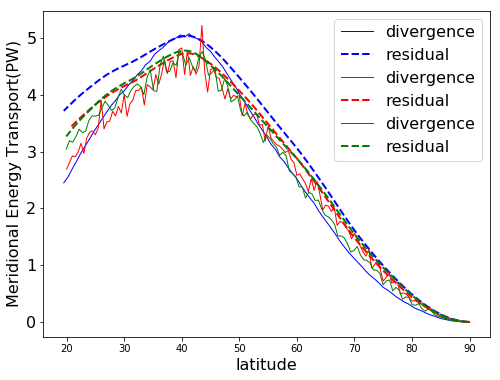

In [18]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  AMET residual & divergence 20N - 90N !@#$%^&***********')
    fig1 = plt.figure()
    fig1.set_size_inches(8, 6)
    plt.plot(latitude_AMET_ERAI, np.mean(AMET_div_int_ERAI_series,0),'b-',
             linewidth=1.0,label='divergence')
    plt.plot(latitude_fields_ERAI[:95], np.mean(AMET_res_int_ERAI_series[:,:95],0), 'b--',
             linewidth=2.0, label='residual')
    plt.plot(latitude_AMET_MERRA2, np.mean(AMET_div_int_MERRA2_series,0),'r-',
             linewidth=1.0,label='divergence')
    plt.plot(latitude_fields_MERRA2[:140], np.mean(AMET_res_int_MERRA2_series[:,:140],0), 'r--',
             linewidth=2.0, label='residual')
    plt.plot(latitude_AMET_JRA55[:125], np.mean(AMET_div_int_JRA55_series[:-24,:125],0),'g-',
             linewidth=1.0,label='divergence')
    plt.plot(latitude_fields_JRA55[:125], np.mean(AMET_res_int_JRA55_series[:,:125],0), 'g--',
             linewidth=2.0, label='residual')
    plt.xlabel("latitude",fontsize=16)
   #plt.xticks(,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=1, prop={'size': 16})
    plt.show()
    fig1.savefig(os.path.join(output_path,'AMET_res_div.png'),dpi=300)
    plt.close(fig1)

*******************  postprocess  *********************
***********!@#$%^&*  AMET residual & divergence 60N!@#$%^&***********


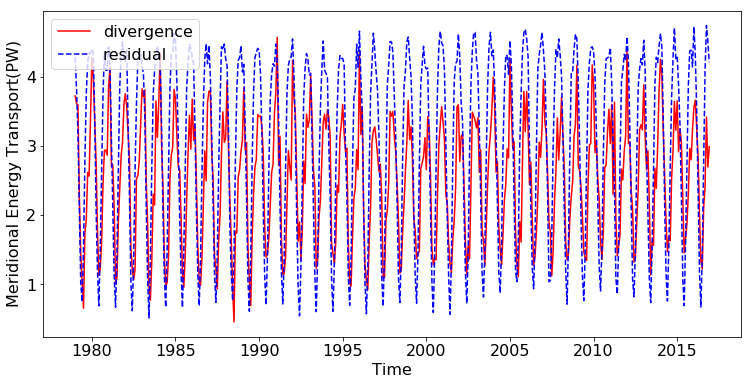

mean of divergence
2.52137809887267
mean of residual
3.0599991087937206


In [15]:
    print ('*******************  postprocess era *********************')
    print ('***********!@#$%^&*  Energy Transport - ERAI  !@#$%^&***********')
    print ('***********!@#$%^&*  AMET residual & divergence 60N!@#$%^&***********')
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    
    fig2 = plt.figure()
    fig2.set_size_inches(12.5, 6)
    plt.plot(index[:], AMET_div_int_ERAI_series[:,40],'r-',
             linewidth=1.5,label='divergence')
    plt.plot(index[:], AMET_res_int_ERAI_series[:,40],
             'b--', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig2.savefig(os.path.join(output_path,'AMET_res_div_60N_era.png'),dpi=300)
    plt.close(fig2)
    # statistics
    print('mean of divergence')
    print(np.mean(AMET_div_int_ERAI_series[:,40]))
    print('mean of residual')
    print(np.mean(AMET_res_int_ERAI_series[:,40]))

*******************  postprocess merra *********************
***********!@#$%^&*  AMET residual & divergence 60N!@#$%^&***********


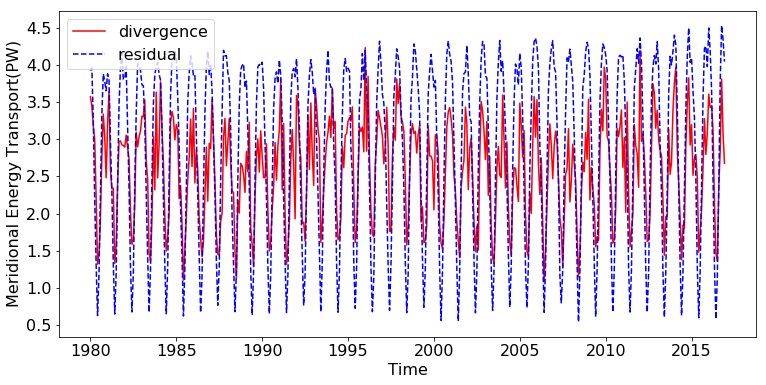

mean of divergence
2.5806875596456087
mean of residual
2.878948342454463


In [17]:
    print ('*******************  postprocess merra *********************')
    print ('***********!@#$%^&*  Energy Transport - MERRA2  !@#$%^&***********')
    print ('***********!@#$%^&*  AMET residual & divergence 60N!@#$%^&***********')
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    
    fig21 = plt.figure()
    fig21.set_size_inches(12.5, 6)
    plt.plot(index[12:], AMET_div_int_MERRA2_series[:,80],'r-',
             linewidth=1.5,label='divergence')
    plt.plot(index[12:], AMET_res_int_MERRA2_series[:,60],
             'b--', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig21.savefig(os.path.join(output_path,'AMET_res_div_60N_merra.png'),dpi=300)
    plt.close(fig21)
    # statistics
    print('mean of divergence')
    print(np.mean(AMET_div_int_MERRA2_series[:,80]))
    print('mean of residual')
    print(np.mean(AMET_res_int_MERRA2_series[:,60]))

*******************  postprocess jra *********************
***********!@#$%^&*  AMET residual & divergence 60N!@#$%^&***********


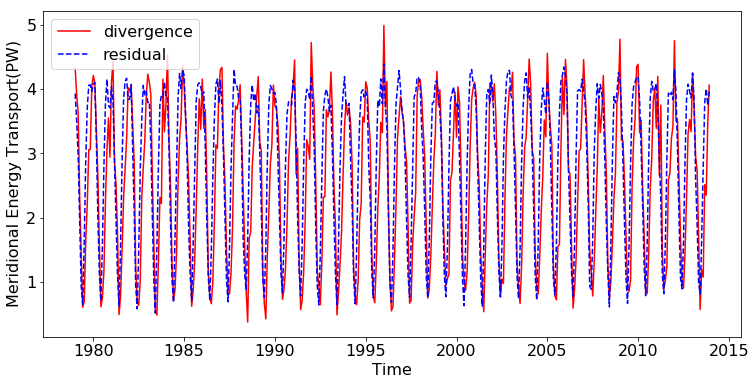

mean of divergence
2.5602286057049355
mean of residual
2.8967026086335212


In [18]:
    print ('*******************  postprocess jra *********************')
    print ('***********!@#$%^&*  Energy Transport - JRA55  !@#$%^&***********')
    print ('***********!@#$%^&*  AMET residual & divergence 60N!@#$%^&***********')
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    
    fig22 = plt.figure()
    fig22.set_size_inches(12.5, 6)
    plt.plot(index[:-36], AMET_div_int_JRA55_series[:-24,53],'r-',
             linewidth=1.5,label='divergence')
    plt.plot(index[:-36], AMET_res_int_JRA55_series[:,53],
             'b--', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig22.savefig(os.path.join(output_path,'AMET_res_div_60N_jra.png'),dpi=300)
    plt.close(fig22)
    # statistics
    print('mean of divergence')
    print(np.mean(AMET_div_int_JRA55_series[:-24,53]))
    print('mean of residual')
    print(np.mean(AMET_res_int_JRA55_series[:,53]))

*******************  postprocess  *********************
***********!@#$%^&*  AMET residual & divergence anomalies 60N!@#$%^&***********
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!


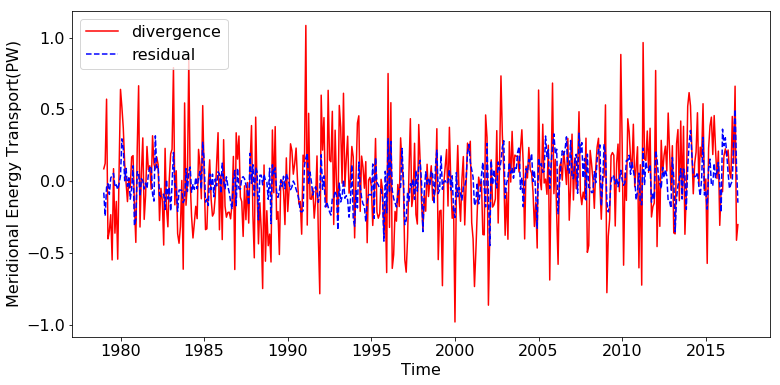

std of divergence
0.3198688764850559
std of residual
0.1402194915898489


In [9]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  Energy Transport - ERAI  !@#$%^&***********')
    print ('***********!@#$%^&*  AMET residual & divergence anomalies 60N!@#$%^&***********')
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    # take anomalies
    stat_AMET_div_ERAI = meta.statistics.operator(AMET_div_int_ERAI_series[:,40])
    stat_AMET_div_ERAI.anomaly(Dim_month=False)
    stat_AMET_res_ERAI = meta.statistics.operator(AMET_res_int_ERAI_series[:,40])
    stat_AMET_res_ERAI.anomaly(Dim_month=False)    
    
    fig3 = plt.figure()
    fig3.set_size_inches(12.5, 6)
    plt.plot(index[:], stat_AMET_div_ERAI._anomaly,'r-',
             linewidth=1.5,label='divergence')
    plt.plot(index[:], stat_AMET_res_ERAI._anomaly,
             'b--', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig3.savefig(os.path.join(output_path,'AMET_res_div_anomaly_60N_era.png'),dpi=300)
    plt.close(fig3)
    # statistics
    print('std of divergence')
    print(np.std(stat_AMET_div_ERAI._anomaly))
    print('std of residual')
    print(np.std(stat_AMET_res_ERAI._anomaly))    

*******************  postprocess  *********************
***********!@#$%^&*  Energy Transport - MERRA2  !@#$%^&***********
***********!@#$%^&*  AMET residual & divergence anomalies 60N!@#$%^&***********
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!


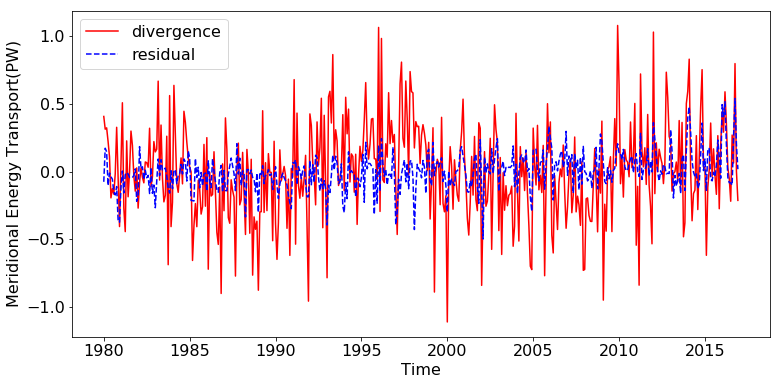

std of divergence
0.35275539025415875
std of residual
0.13860082237620933


In [10]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  Energy Transport - MERRA2  !@#$%^&***********')
    print ('***********!@#$%^&*  AMET residual & divergence anomalies 60N!@#$%^&***********')
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    # take anomalies
    stat_AMET_div_MERRA2 = meta.statistics.operator(AMET_div_int_MERRA2_series[:,80])
    stat_AMET_div_MERRA2.anomaly(Dim_month=False)
    stat_AMET_res_MERRA2 = meta.statistics.operator(AMET_res_int_MERRA2_series[:,60])
    stat_AMET_res_MERRA2.anomaly(Dim_month=False)    
    
    fig31 = plt.figure()
    fig31.set_size_inches(12.5, 6)
    plt.plot(index[12:], stat_AMET_div_MERRA2._anomaly,'r-',
             linewidth=1.5,label='divergence')
    plt.plot(index[12:], stat_AMET_res_MERRA2._anomaly,
             'b--', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig31.savefig(os.path.join(output_path,'AMET_res_div_anomaly_60N_merra.png'),dpi=300)
    plt.close(fig31)
    # statistics
    print('std of divergence')
    print(np.std(stat_AMET_div_MERRA2._anomaly))
    print('std of residual')
    print(np.std(stat_AMET_res_MERRA2._anomaly))    

*******************  postprocess  *********************
***********!@#$%^&*  Energy Transport - JRA55  !@#$%^&***********
***********!@#$%^&*  AMET residual & divergence anomalies 60N!@#$%^&***********
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!


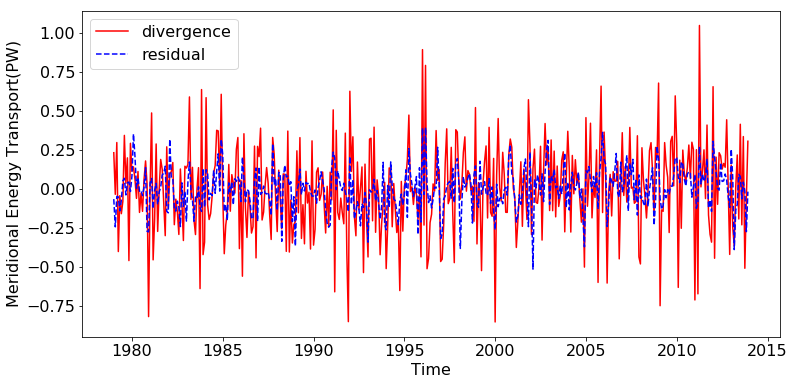

std of divergence
0.28724909938546905
std of residual
0.1357584097236335


In [12]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  Energy Transport - JRA55  !@#$%^&***********')
    print ('***********!@#$%^&*  AMET residual & divergence anomalies 60N!@#$%^&***********')
    # take anomalies
    stat_AMET_div_JRA55 = meta.statistics.operator(AMET_div_int_JRA55_series[:-24,53])
    stat_AMET_div_JRA55.anomaly(Dim_month=False)
    stat_AMET_res_JRA55 = meta.statistics.operator(AMET_res_int_JRA55_series[:,53])
    stat_AMET_res_JRA55.anomaly(Dim_month=False)
    
    fig32 = plt.figure()
    fig32.set_size_inches(12.5, 6)
    plt.plot(index[:-36], stat_AMET_div_JRA55._anomaly,'r-',
             linewidth=1.5,label='divergence')
    plt.plot(index[:-36], stat_AMET_res_JRA55._anomaly,
             'b--', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig32.savefig(os.path.join(output_path,'AMET_res_div_anomaly_60N_jra.png'),dpi=300)
    plt.close(fig32)
    # statistics
    print('std of divergence')
    print(np.std(stat_AMET_div_JRA55._anomaly))
    print('std of residual')
    print(np.std(stat_AMET_res_JRA55._anomaly))    

*******************  postprocess  *********************
***********!@#$%^&*  AMET residual & divergence anomalies 60N!@#$%^&***********
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!


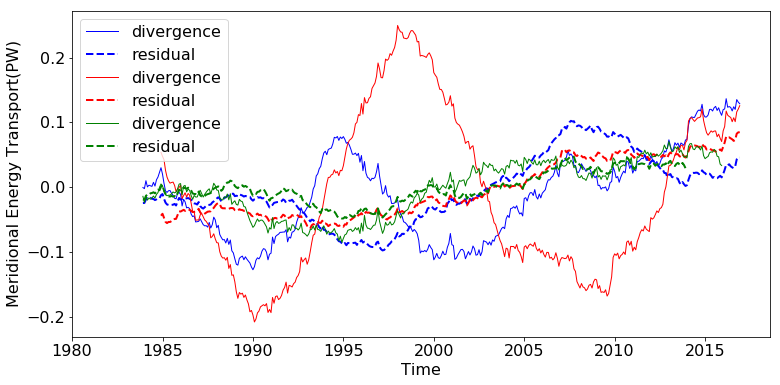

std of divergence - ERAI
0.06799931657497507
std of residual - ERAI
0.05109024224636256
std of divergence - MERRA2
0.12159324028174026
std of residual - MERRA2
0.043668578694791044
std of divergence - JRA55
0.04269698402282107
std of residual - JRA55
0.024627013270788808
mean of divergence - ERAI
-0.010114497404254654
mean of residual - ERAI
-0.003743459542879066
mean of divergence - MERRA2
-0.012120136295336838
mean of residual - MERRA2
-0.0034117857638386044
mean of divergence - JRA55
-0.0021204625973013395
mean of residual - JRA55
-0.0005359274546692974
Correlation AMET-Divergence ERAI & MERRA2
0.1835164180568071
Correlation AMET-Divergence ERAI & JRA55
0.3066710187795962
Correlation AMET-Residual ERAI & MERRA2
0.8381488214512742
Correlation AMET-Residual ERAI & JRA55
0.9227091279678201


In [22]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  AMET residual & divergence anomalies 60N!@#$%^&***********')
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    # take anomalies
    stat_AMET_div_ERAI = meta.statistics.operator(AMET_div_int_ERAI_series[:,40])
    stat_AMET_div_ERAI.anomaly(Dim_month=False)
    stat_AMET_div_ERAI.lowpass()
    
    stat_AMET_res_ERAI = meta.statistics.operator(AMET_res_int_ERAI_series[:,40])
    stat_AMET_res_ERAI.anomaly(Dim_month=False)    
    stat_AMET_res_ERAI.lowpass()
    
    stat_AMET_div_MERRA2 = meta.statistics.operator(AMET_div_int_MERRA2_series[:,80])
    stat_AMET_div_MERRA2.anomaly(Dim_month=False)
    stat_AMET_div_MERRA2.lowpass()
    
    stat_AMET_res_MERRA2 = meta.statistics.operator(AMET_res_int_MERRA2_series[:,60])
    stat_AMET_res_MERRA2.anomaly(Dim_month=False)
    stat_AMET_res_MERRA2.lowpass()

    stat_AMET_div_JRA55 = meta.statistics.operator(AMET_div_int_JRA55_series[:,53])
    stat_AMET_div_JRA55.anomaly(Dim_month=False)
    stat_AMET_div_JRA55.lowpass()
    
    stat_AMET_res_JRA55 = meta.statistics.operator(AMET_res_int_JRA55_series[:,53])
    stat_AMET_res_JRA55.anomaly(Dim_month=False)
    stat_AMET_res_JRA55.lowpass()
    
    fig4 = plt.figure()
    fig4.set_size_inches(12.5, 6)
    plt.plot(index[59:], stat_AMET_div_ERAI._lowpass,'b-',
             linewidth=1.0,label='divergence')
    plt.plot(index[59:], stat_AMET_res_ERAI._lowpass,
             'b--', linewidth=2.0, label='residual')
    plt.plot(index[71:], stat_AMET_div_MERRA2._lowpass,'r-',
             linewidth=1.0,label='divergence')
    plt.plot(index[71:], stat_AMET_res_MERRA2._lowpass,
             'r--', linewidth=2.0, label='residual')
    plt.plot(index[59:-12], stat_AMET_div_JRA55._lowpass,'g-',
             linewidth=1.0,label='divergence')
    plt.plot(index[59:-36], stat_AMET_res_JRA55._lowpass,
             'g--', linewidth=2.0, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig4.savefig(os.path.join(output_path,'AMET_res_div_anomaly_lowpass_5y_60N.png'),dpi=300)
    plt.close(fig4)
    # statistics
    print('std of divergence - ERAI')
    print(np.std(stat_AMET_div_ERAI._lowpass))
    print('std of residual - ERAI')
    print(np.std(stat_AMET_res_ERAI._lowpass))
    print('std of divergence - MERRA2')
    print(np.std(stat_AMET_div_MERRA2._lowpass))
    print('std of residual - MERRA2')
    print(np.std(stat_AMET_res_MERRA2._lowpass))
    print('std of divergence - JRA55')
    print(np.std(stat_AMET_div_JRA55._lowpass))
    print('std of residual - JRA55')
    print(np.std(stat_AMET_res_JRA55._lowpass))
    print ('Correlation AMET-Divergence ERAI & MERRA2')
    _, _, Corr_AMET_Res, _, _ = stats.linregress(stat_AMET_div_MERRA2._lowpass,
                                                 stat_AMET_div_ERAI._lowpass[12:])
    print (Corr_AMET_Res)
    print ('Correlation AMET-Divergence ERAI & JRA55')
    _, _, Corr_AMET_Res, _, _ = stats.linregress(stat_AMET_div_JRA55._lowpass,
                                                 stat_AMET_div_ERAI._lowpass[:-12])
    print (Corr_AMET_Res)    
    print ('Correlation AMET-Residual ERAI & MERRA2')
    _, _, Corr_AMET_Res, _, _ = stats.linregress(stat_AMET_res_MERRA2._lowpass,
                                                 stat_AMET_res_ERAI._lowpass[12:])
    print (Corr_AMET_Res)
    print ('Correlation AMET-Residual ERAI & JRA55')
    _, _, Corr_AMET_Res, _, _ = stats.linregress(stat_AMET_res_JRA55._lowpass,
                                                 stat_AMET_res_ERAI._lowpass[:-36])
    print (Corr_AMET_Res)    